In [1]:
import os

openai_api_key=os.getenv("openai_api_key")
AZURE_OPENAI_DEPLOYMENT_NAME = os.getenv('deployment_name')
AZURE_OPENAI_ENDPOINT = os.getenv("endpoint")
AZURE_OPENAI_API_VERSION = os.getenv("version")

In [2]:
from langchain.chat_models import AzureChatOpenAI

llm= AzureChatOpenAI(
    deployment_name=AZURE_OPENAI_DEPLOYMENT_NAME,
    openai_api_base=AZURE_OPENAI_ENDPOINT,
    openai_api_key=openai_api_key,
    openai_api_version=AZURE_OPENAI_API_VERSION
)

C:\Users\yash2\AppData\Local\Temp\ipykernel_7288\3069890798.py:3: LangChainDeprecationWarning: The class `AzureChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import AzureChatOpenAI``.
  llm= AzureChatOpenAI(
d:\Yash-Python\Lib\site-packages\langchain_community\chat_models\azure_openai.py:174: UserWarning: As of openai>=1.0.0, Azure endpoints should be specified via the `azure_endpoint` param not `openai_api_base` (or alias `base_url`). Updating `openai_api_base` from https://soa-openai-sc.openai.azure.com/ to https://soa-openai-sc.openai.azure.com/openai.
  warnings.warn(
d:\Yash-Python\Lib\site-packages\langchain_community\chat_models\azure_openai.py:181: UserWarning: As of openai>=1.0.0, if `deployment_name` (or alias `azure_deployment`) is specifie

In [3]:
from langchain_core.tools import Tool
from langchain_google_community import GoogleSearchAPIWrapper

search = GoogleSearchAPIWrapper(
    k=2
)

google_search = Tool(
    name="google_search",
    func=search.run,
    description="Search Engine",
    max_tokens=500
)

In [4]:
from typing import List, Dict, Optional
from pydantic import BaseModel, Field, validator

class Enrich(BaseModel):
    Product: str = Field(description="Name/Type of the product in the query", default="N/A")
    Dimension: str = Field(description="Dimension of product", default="N/A")
    Enriched_Query: str = Field(description="Reformulate the user query into a well-defined and detailed format", default="N/A")

class Valid_1(BaseModel):
    status: bool = Field(description="Validation status either true/false", default=False)
    suggestion: str = Field(description="If status is True, provide detailed improvement suggestions. If status is False, write N/A", default="N/A")

class MatchResult(BaseModel):
    Product: bool = Field(description="Does product matched, true or false.", default=False)
    Dimension: bool = Field(description="Does dimension of product matched, true or false.", default=False)
    Numerical_Entities: Optional[List[str]] = Field(
        description="list of the numerical entities",
        default_factory=list
    )
    Non_Numerical_Entities: Optional[List[str]] = Field(
        description="list of non-numerical entities",
        default_factory=list
    )

    @validator('Numerical_Entities', pre=True)
    def convert_numerical_to_str(cls, v):
        if v is None:
            return []
        return [str(x) for x in v]

class ProductDetails(BaseModel):
    Product_id: str=Field(description="Product id")
    description: str=Field(description="Description of the product")
    Matching_Numerical_Entities: Optional[int] = Field(description="Number of Matching Numerical Entities", default=0)
    Matching_Non_Numerical_Entities: Optional[int] = Field(description="Number of matched non-numerical entities", default=0)

class Product(BaseModel):
    Product_id: Optional[str]
    Manufacturer_Part_No: Optional[str] = Field(alias="Manufacturer Part No. ")
    description: Optional[str]
    stock_type: Optional[int]
    additional_information: Optional[Dict[str, str]]=Field(default_factory={})

class State(BaseModel):
    query: Optional[str]=Field(default=" ")
    context: Optional[str]=Field(default=" ")
    output_1: Optional[Enrich]=Field(default_factory=Enrich)
    valid: Valid_1=Field(default_factory=Valid_1)

C:\Users\yash2\AppData\Local\Temp\ipykernel_7288\2622186525.py:25: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.8/migration/
  @validator('Numerical_Entities', pre=True)


In [5]:
check=State()
check

State(query=' ', context=' ', output_1=Enrich(Product='N/A', Dimension='N/A', Enriched_Query='N/A'), valid=Valid_1(status=False, suggestion='N/A'))

In [6]:
def demo(state:State):
    val=state.valid
    return val

In [7]:
# state=State()
# print(demo(state))

In [8]:
def google(state:State)->str:
    return {"context":google_search.invoke(state.query)}

In [9]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

In [10]:
# google_search.invoke("2 in x 2 in x 3/4 in thrd tee C.S")

In [11]:
def query_enrich(state: State)->Dict[str,str]:
    system_prompt = """
        You are given a product description along with some context. Your task is to extract relevant information and return it as a structured. It should include fields such as the product's quantity, name, and no additional details that can be inferred from the context.
        Only give the output, no description is needed.
        You are also provided with the possible changes that should be made while giving output.
        
        Query:{query}
        Context:{context}
        Suggestion:{suggest}

        Output:
        Product:(Name/Type of the product in the query),
        Dimension:(Dimension of product),
        Enriched_Query:(Reformulate the user query into a well-defined and detailed format by utilizing both the query and the provided context.),

        MUST INCLUDE THESE THREE PARAMETERS IN OUTPUT.
        In {format}
        """

    parser = JsonOutputParser(pydantic_object=Enrich)

    prompt = PromptTemplate(
        template=system_prompt,
        input_variables=["query","context","suggest"],
        partial_variables={"format": parser.get_format_instructions()},
    )
    chain = prompt | llm | parser

    # Get the response as a Pydantic model
    response = chain.invoke({
        "query":state.query,
        "context":state.context,
        "suggest":state.valid.suggestion
    })

    return {"output_1": response}

In [12]:
def valid_1(state: State)->Dict[str,str]:
    system_prompt = """
        You are an expert Supervisor Model tasked with evaluating the quality of outputs generated by an AI agent. Your responsibilities include:
        1. Checking if the output meets the specified expectations.
        2. Providing actionable feedback if the output deviates from expectations.

        ### Evaluation Criteria:
        - **Status**:
        - Mark `status` as **True** if the output does not meet the expectations, and provide improvement suggestions.
        - Mark `status` as **False** if the output aligns with expectations, and write "N/A" in the `suggestion` field.

        ### Expectations:
        The output should:
        1. Extract relevant information from the input query and context.
        2. Return the information in a **structured format**, including the following fields:
        - **Product**: The name or type of the product mentioned in the query.
        - **Dimension**: The dimensions of the product, if provided in the context.
        - **Enriched_Query**: A reformulated version of the user query that is well-defined, detailed, and utilizes both the query and context.
        3. Avoid including additional or inferred details not explicitly mentioned in the query or context.

        ### Input Details:
        - **Query**: {query}
        - **Context**: {context}

        ### AI Agent's Output:
        - **Output**: {output}

        ### Required Output:
        You must return:
        status: (True/False) — Whether the output meets expectations.
        suggestion: (If `status` is True, provide detailed improvement suggestions. If `status` is False, write "N/A".)

        Format:{format}
"""

    parser = JsonOutputParser(pydantic_object=Valid_1)

    prompt = PromptTemplate(
        template=system_prompt,
        input_variables=["query","context","output"],
        partial_variables={"format": parser.get_format_instructions()},
    )
    chain = prompt | llm | parser

    # Get the response as a Pydantic model
    response = chain.invoke({
        "query":state.query,
        "context":state.context,
        "output":state.output_1
    })   
    # state.valid=response
    return {"valid":response}


In [13]:
def condition_1(state:State)->str:
    if state.valid.status:
        return "repeat"
    return "end"

In [14]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

graph_builder.add_node("search", google)
graph_builder.add_node("enrichment", query_enrich)
graph_builder.add_node("validator_1", valid_1)
graph_builder.add_edge(START, "search")
graph_builder.add_edge("search", "enrichment")
graph_builder.add_edge("enrichment","validator_1")
# graph_builder.add_edge("validator",END)
graph_builder.add_conditional_edges(
    "validator_1",
     condition_1, 
    {
        "repeat": "enrichment",
        "end": END
    }
)

d:\Yash-Python\Lib\site-packages\langgraph\graph\graph.py:36: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langgraph.pregel import Channel, Pregel


In [15]:
graph=graph_builder.compile()

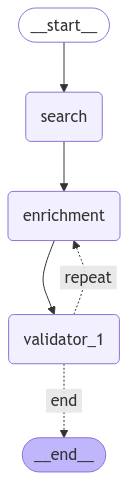

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:

    pass

In [17]:
user_input="3 in(inch) schedule sch(schedule) 10 316 90s(90 short radius) 90 degree elbow"

In [18]:
# user_input="Hello how are you!"

In [136]:
response = graph.invoke({
    "query": user_input,
    "valid":Valid_1(status=True, suggestion="No no")
})

In [137]:
response['output_1']

{'Product': '90 degree short radius elbow',
 'Dimension': '3 inch, short radius',
 'Enriched_Query': '3 inch schedule 10 316 90 degree short radius elbow, ANSI B16.9 Butt Weld'}

In [138]:
response['valid']

{'status': False, 'suggestion': 'N/A'}